# Генерация датасета


In [2]:
import os
import random as rnd
import cv2
import numpy as np
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
import math


## Загрузка из MyDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
LOGO_URLS = ['/content/drive/MyDrive/logo_dataset/logos/'+el for el in os.listdir('/content/drive/MyDrive/logo_dataset/logos/')]
BG_URLS = ['/content/drive/MyDrive/logo_dataset/backgrounds/'+el for el in os.listdir('/content/drive/MyDrive/logo_dataset/backgrounds')]

## Локальная загрузка файлов

In [ ]:
LOGO_URLS = ['./content/logo_dataset/logos/'+el for el in os.listdir('./content/logo_dataset/logos')]
BG_URLS = ['./content/logo_dataset/backgrounds/'+el for el in os.listdir('./content/logo_dataset/backgrounds')]

Создание директорий для Colab

In [7]:
os.mkdir('/content/dataset')
os.mkdir('/content/dataset/train')
os.mkdir('/content/dataset/val')
os.mkdir('/content/dataset/train/images')
os.mkdir('/content/dataset/train/labels')
os.mkdir('/content/dataset/val/images')
os.mkdir('/content/dataset/val/labels')
# os.mkdir('/content/dataset/test')

 ## Класс генерации и хранения фонов и логотипов

In [43]:
SAMPLE_INDEX = 0
class DataHolder:
    def __init__(self, save_backgrounds=False, num_backgrounds=50):
        self.logos = list()
        self.source_bgs = list()
        self.bgs = list()
        self.target_size = (600, 600)
        self.save_backgrounds = save_backgrounds
        self.num_backgrounds = num_backgrounds

    def clean_train() -> None:
      for el in os.listdir('/content/dataset/train/images'):
        os.remove('/content/dataset/train/images/'+el)
      for el in os.listdir('/content/dataset/train/labels'):
          os.remove('/content/dataset/train/labels/'+el)

    def clean_val() -> None:
        for el in os.listdir('./content/dataset/val/images'):
            os.remove('./content/dataset/val/images/'+el)
        for el in os.listdir('./content/dataset/val/labels'):
            os.remove('./content/dataset/val/labels/'+el)

    def clean_test() -> None:
      for el in os.listdir('/content/dataset/test'):
        os.remove('/content/dataset/test/'+el)

    @staticmethod
    def resize_logo(logo: np.array, width = None, height = None, inter = cv2.INTER_AREA) -> np.array:
      dim = None
      (h, w) = logo.shape[:2]
      if width is None and height is None:
          return logo

      if width is None:
          r = height / float(h)
          dim = (int(w * r), height)
      else:
          r = width / float(w)
          dim = (width, int(h * r))

      resized = cv2.resize(logo, dim, interpolation = inter)
      return resized


    def prepare_data(self) -> None:
        for logo in LOGO_URLS:
            lg = cv2.imread(logo, cv2.IMREAD_UNCHANGED)
            self.logos.append(self.resize_logo(lg, 150))
        for bg in BG_URLS:
            back = cv2.imread(bg, cv2.IMREAD_UNCHANGED)
            back = cv2.cvtColor(back, cv2.COLOR_RGB2RGBA)
            self.source_bgs.append(back)
        counter = 0
        f = False
        for _ in range(self.num_backgrounds):
            for bg in self.source_bgs:
                self.generate_bg(bg)
                counter += 1
                if counter == self.num_backgrounds:
                  f = True
                  break
            if f:
              break

        if self.save_backgrounds:
            self.save_generated_backgrounds()

    def save_generated_backgrounds(self) -> None:
        for i, bg in enumerate(self.bgs):
            cv2.imwrite(f"/content/dataset/train/images/sample_{i}.png", bg)


    def generate_bg(self, source_bg: np.array) -> None:
      global SAMPLE_INDEX
      bgs = rnd.sample(self.source_bgs, 3)
      source_bg = cv2.resize(source_bg, self.target_size)
      for bg in bgs:
        scale = rnd.uniform(1.0, 2.5)
        scaled_background = cv2.resize(bg, (int(self.target_size[0] * scale), int(self.target_size[1] * scale)))
        angle = rnd.uniform(-60, 60)
        M = cv2.getRotationMatrix2D((self.target_size[0] / 2, self.target_size[1] / 2), angle, 1)
        rotated_background = cv2.warpAffine(scaled_background, M, self.target_size)
        x_offset = rnd.randint(0, self.target_size[0] - rotated_background.shape[1])
        y_offset = rnd.randint(0, self.target_size[1] - rotated_background.shape[0])
        mask = cv2.threshold(rotated_background, 0, 255, cv2.THRESH_BINARY)[1]
        alpha = rnd.uniform(0.3, 0.6)
        rotated_background_with_alpha = cv2.addWeighted(rotated_background, alpha, source_bg, 1 - alpha, 0)
        source_bg[y_offset:y_offset+self.target_size[1], x_offset:x_offset+self.target_size[0]] = \
            source_bg[y_offset:y_offset+self.target_size[1], x_offset:x_offset+self.target_size[0]] * (1 - mask / 255) + \
            rotated_background_with_alpha * (mask / 255)
      SAMPLE_INDEX += 1
      self.bgs.append(source_bg)

In [66]:
DataHolder.clean_train()
# DataHolder.clean_val()
# DataHolder.clean_test()

## Класс генерации картинок

In [67]:
SAMPLE_INDEX_1 = 0
boxes = []
class ImageGenerator:
    def __init__(self, logos_per_bg_count=1, total_images=100):
        self.logos_per_bg_count = logos_per_bg_count
        self.total_images = total_images
        self.holder = DataHolder(num_backgrounds=self.total_images//2)
        self.holder.prepare_data()
        self.logos = self.holder.logos
        self.logos_per_image = math.ceil(self.total_images // len(self.logos))

    def main(self, path: str):
        global SAMPLE_INDEX_1

        for ind, lg in enumerate(self.logos):
            for i in range(self.logos_per_image):
                lst = []
                clss = []
                bg = rnd.choice(self.holder.bgs)
                lst.append(self.make_logo_roi(lg, np.copy(bg), i + 1))
                clss.append(ind)
                for _ in range(self.logos_per_bg_count - 1):
                    lg = rnd.choice(self.logos)
                    clss.append(self.logos.index(lg))
                    lst.append(self.make_logo_roi(lg, np.copy(bg), i + 1))
                self.make_sample(np.copy(bg), lst, f"{path}/labels/sample_{SAMPLE_INDEX_1}", clss, i + 1, f"{path}/images/sample_{SAMPLE_INDEX_1}")
                SAMPLE_INDEX_1 += 1

    def make_sample(self, bg: np.array, rois: list, save_path: str, clss: list, sample: int, logo_path):
        box_temp = []
        for roi in rois:
            bg[roi[0] : roi[1], roi[2] : roi[3]] = roi[4]
            box_temp.append(roi[0:4])
        boxes.append(box_temp)

        if 0.15 * self.logos_per_image < sample < 0.25 * self.logos_per_image or 0.65 * self.logos_per_image < sample < 0.75 * self.logos_per_image:
            kernel_size = rnd.randint(5, 15)
            if kernel_size % 2 == 0:
                kernel_size += 1
            bg = cv2.GaussianBlur(bg, (kernel_size, kernel_size), 0)

        label = open(f"/content/dataset/{save_path}.txt", "w+")
        for i, roi in enumerate(rois):
            x_center = ((roi[2] + roi[3]) / 2) / bg.shape[1]
            y_center = ((roi[0] + roi[1]) / 2) / bg.shape[0]
            norm_width = (roi[3] - roi[2]) / bg.shape[1]
            norm_height = (roi[1] - roi[0]) / bg.shape[0]
            label.write(f"{clss[i]} {x_center} {y_center} {norm_width} {norm_height}\n")

        label.close()
        cv2.imwrite(f"/content/dataset/{logo_path}.png", bg)

    def make_logo_roi(self, logo: np.array, bg: np.array, sample: int) -> tuple:
        logo = DataHolder.resize_logo(logo, rnd.randint(150, 350))
        logo = ImageGenerator.apply_random_color_distortion(logo)
        if sample < 0.6 * self.logos_per_image:
            logo = ImageGenerator.rotate_logo(logo, rnd.randint(-45, 45))
        logo = ImageGenerator.apply_random_perspective_distortion(logo)
        bg = cv2.cvtColor(bg, cv2.COLOR_RGB2RGBA)
        x_offset, y_offset = rnd.randint(0, bg.shape[1] - logo.shape[1]), rnd.randint(0, bg.shape[0] - logo.shape[0])
        x_end, y_end = (x_offset + logo.shape[1], y_offset + logo.shape[0])
        roi = bg[y_offset:y_offset+logo.shape[0], x_offset:x_offset+logo.shape[1]]
        ret, mask = cv2.threshold(logo[:, :, 3], 0, 255, cv2.THRESH_BINARY)
        bg = cv2.bitwise_or(roi, roi, mask=cv2.bitwise_not(mask))
        fg = cv2.bitwise_and(logo, logo, mask=mask)
        final_roi = cv2.add(bg, fg)

        return y_offset, y_end, x_offset, x_end, final_roi

    @staticmethod
    def rotate_logo(logo: np.array, angle: int) -> np.array:
        h, w = logo.shape[:2]
        img_c = (w / 2, h / 2)

        rot = cv2.getRotationMatrix2D(img_c, angle, 1)

        rad = np.radians(angle)
        sin = np.sin(rad)
        cos = np.cos(rad)
        b_w = int((h * abs(sin)) + (w * abs(cos)))
        b_h = int((h * abs(cos)) + (w * abs(sin)))

        rot[0, 2] += ((b_w / 2) - img_c[0])
        rot[1, 2] += ((b_h / 2) - img_c[1])

        outImg = cv2.warpAffine(logo, rot, (b_w, b_h), flags=cv2.INTER_LINEAR)
        return outImg

    @staticmethod
    def apply_random_color_distortion(image, max_shift=150):
        red_shift = rnd.randint(-max_shift, max_shift)
        green_shift = rnd.randint(-max_shift, max_shift)
        blue_shift = rnd.randint(-max_shift, max_shift)

        distorted_image = image.copy()
        distorted_image[:, :, 0] = np.clip(image[:, :, 0] + blue_shift, 0, 255)
        distorted_image[:, :, 1] = np.clip(image[:, :, 1] + green_shift, 0, 255)
        distorted_image[:, :, 2] = np.clip(image[:, :, 2] + red_shift, 0, 255)

        return distorted_image

    @staticmethod
    def distance(point1, point2):
        return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    def apply_random_perspective_distortion(image, max_distortion=0.25):
        height, width, _ = image.shape
        points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
        x1 = 0
        y1 = 0
        x2 = width
        y2 = 0
        x3 = 0
        y3 = height
        x4 = width
        y4 = height


        offset_x1 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y1 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x2 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y2 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x3 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y3 = rnd.uniform(0, max_distortion) * image.shape[0]
        offset_x4 = rnd.uniform(0, max_distortion) * image.shape[1]
        offset_y4 = rnd.uniform(0, max_distortion) * image.shape[0]

        new_x1, new_y1 = x1 + offset_x1, y1 + offset_y1
        new_x2, new_y2 = x2 + offset_x2, y2 + offset_y2
        new_x3, new_y3 = x3 + offset_x3, y3 + offset_y3
        new_x4, new_y4 = x4 + offset_x4, y4 + offset_y4

        new_width = max(new_x1, new_x2, new_x3, new_x4)
        new_heigth = max(new_y1, new_y2, new_y3, new_y4)

        pts1 = np.float32([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
        pts2 = np.float32([[new_x1, new_y1], [new_x2, new_y2], [new_x3, new_y3], [new_x4, new_y4]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)

        distorted_image = cv2.warpPerspective(image, matrix, (int(new_width), int(new_heigth)))

        return distorted_image

In [ ]:
generator = ImageGenerator(2, 60)
generator.main()

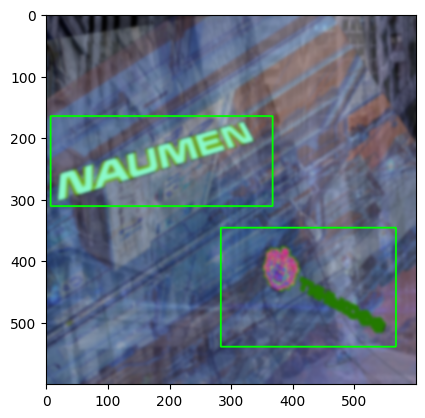

In [69]:
ind = 11
im = cv2.imread(f'/content/dataset/train/images/sample_{ind}.png')
for i in boxes[ind]:
  cv2.rectangle(im, (i[2], i[0]), (i[3], i[1]), (0, 255, 0), 2)
plt.imshow(im)

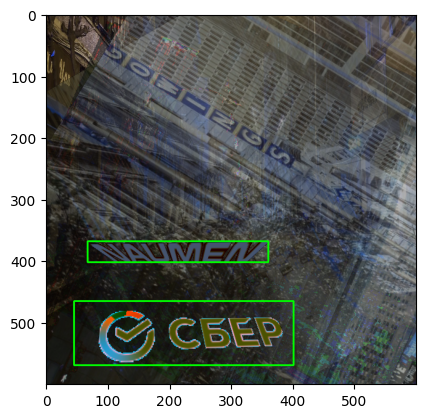

In [70]:
ind = 15
im = cv2.imread(f'/content/dataset/train/images/sample_{ind}.png')
for i in boxes[ind]:
  cv2.rectangle(im, (i[2], i[0]), (i[3], i[1]), (0, 255, 0), 2)
plt.imshow(im)